# Deep Learning with Mr. Lepetit - Project one
## CentraleSupelec - December 2018
## Quentin Pradelle

__I've tried to comment the code to explain the different steps of the project, hopefully it will make it easily understandable__

In [1]:
# Importing libraries and setting up image_size to 72

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import numpy as np
import keras
from keras import utils as np_utils
#On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

Using TensorFlow backend.


__Here, we use the code provided by the teacher. It is composed of:__ <br>
1. Functions that generate drawings of Triangles, Rectangles and Disks
2. Functions that generate datasets of these drawings in random order (For training and test sets) <br>
3. Some visualization functions <br>

In [2]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize = (figsize, figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0, figsize)
    ax.set_ylim(0, figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype = np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    # Transform labels to a vector of size 3
    Y = np_utils.to_categorical(Y, 3)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    # Y_test = np_utils.to_categorical(Y_test, 3)
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent = [-0.15,1.15,-0.15,1.15], cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()
    
def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]



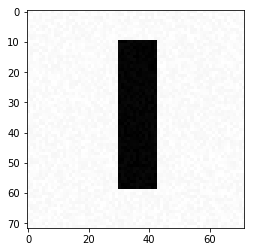

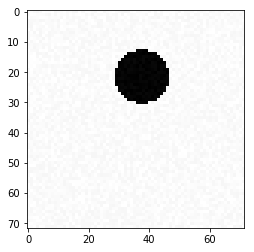

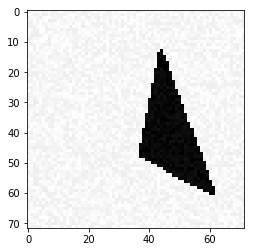

In [3]:
# This is a function that plots one image of each of our possible shapes

def test_show_generate():
    im1 = generate_a_rectangle(10, True)
    plt.imshow(im1.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

    plt.show()

    im2 = generate_a_disk(10, True)
    plt.imshow(im2.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

    plt.show()

    [im3, v] = generate_a_triangle(20, True)
    plt.imshow(im3.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

    plt.show()
test_show_generate()

### 3) Simple Classifcation
__Build and train a linear classifer in Keras to classify a image into one of the three possible
categories (i.e. rectangle, disk, triangle)__

In [4]:
################################## 3/ SIMPLE CLASSIFICATION ##############################################

# Generate a training set of images of simple geometric shapes
[X_train, Y_train] = generate_dataset_classification(600, 0.0, False)
[X_test, Y_test] = generate_test_set_classification()

# Taking a look at the shape of our data
print(Y_train.shape)
print(Y_train[0:3])
print(Y_train[:3])
print(Y_test.shape)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
(600, 3)
[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]
[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]
(300, 3)


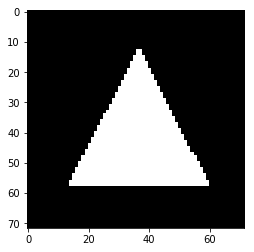

In [5]:
# Plot the image of our first training data
plt.imshow(X_train[0].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap = cm.Greys)


In [6]:
from keras.models import Sequential, Model

# Create a sequential model
model = Sequential()

# Get number of columns in training data
n_cols = X_train.shape[1]
n_cols

5184

In [7]:
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, UpSampling2D

# Here is our first simple classification model
model.add(Dense(3, activation='softmax', input_shape=(X_train.shape[1],)))

# Taking a look at our model 
print(model.summary())

# Taking another look at our data
print ("number of training examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("Y_test shape: " + str(Y_test.shape))
# print ("Y_test: " + str(Y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 15555     
Total params: 15,555
Trainable params: 15,555
Non-trainable params: 0
_________________________________________________________________
None
number of training examples = 600
X_train shape: (600, 5184)
Y_train shape: (600, 3)
Y_test shape: (300, 3)


__Note : Since the 'Adam' optimizer was performing much better, I will only use this one here__

In [8]:
from keras.optimizers import SGD
import keras.backend as K

# Stochatstic gradient descent optimizer with a set of parameters
sgd = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)

# This replaces the metrics['accuracy'] which gives a value error (may be due to tensorflow version)
def get_categorical_accuracy_keras(y_true, y_pred):
    return K.mean(K.equal(K.argmax(y_true, axis=1), K.argmax(y_pred, axis=1)))

# Specifying the optimization parameters of our model: Optimizer and cost function
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=[get_categorical_accuracy_keras])

print(model.output_shape)

(None, 3)


In [12]:
model.fit(X_train, Y_train, epochs = 20, batch_size = 32, verbose=1)

Epoch 1/20
600/600 [==============================] - 0s 71us/step - loss: 0.0207 - get_categorical_accuracy_keras: 1.0000
Epoch 2/20
600/600 [==============================] - 0s 59us/step - loss: 0.0199 - get_categorical_accuracy_keras: 1.0000
Epoch 3/20
600/600 [==============================] - 0s 80us/step - loss: 0.0191 - get_categorical_accuracy_keras: 1.0000
Epoch 4/20
600/600 [==============================] - 0s 85us/step - loss: 0.0185 - get_categorical_accuracy_keras: 1.0000
Epoch 5/20
600/600 [==============================] - 0s 70us/step - loss: 0.0163 - get_categorical_accuracy_keras: 1.0000
Epoch 6/20
600/600 [==============================] - 0s 65us/step - loss: 0.0155 - get_categorical_accuracy_keras: 1.0000
Epoch 7/20
600/600 [==============================] - 0s 66us/step - loss: 0.0152 - get_categorical_accuracy_keras: 1.0000
Epoch 8/20
600/600 [==============================] - 0s 64us/step - loss: 0.0137 - get_categorical_accuracy_keras: 1.0000
Epoch 9/20
600/6

In [13]:

# This function will test our model on random generation for each of the shapes
def testing_linear_classifier(model):
    err = 0

    print("TEST MODEL: ")
    X_test_disk = generate_a_disk()
    X_test_disk = X_test_disk.reshape(1, X_test_disk.shape[0])
    res = model.predict(X_test_disk)
    print(str(res) + "disk")
    if res[0][1] >= 0.99 and res[0][2] <= 0.1 and res[0][0] <= 0.1:
        print("\t\t- ok")
    else:
        print("\t\t-error disk:" + str(res))
        err+=1


    X_test_rect = generate_a_rectangle()
    X_test_rect = X_test_rect.reshape(1, X_test_rect.shape[0])
    res = model.predict(X_test_rect)
    print(str(res) + "rectangle")
    if res[0][0] >= 0.99 and res[0][1] <= 0.1 and res[0][2] <= 0.1:
        print("\t\t- ok")
    else:
        print("\t\t-error rectangle:" + str(res))
        err+=1

    X_test_tri, vect = generate_a_triangle()
    X_test_tri = X_test_tri.reshape(1, X_test_tri.shape[0])
    res = model.predict(X_test_tri)
    print(str(res) + "triangle")
    if res[0][2] >= 0.99 and res[0][1] <= 0.1 and res[0][0] <= 0.1:
        print("\t\t- ok")
    else:
        print("\t\t-error triangle:" + str(res))
        err+=1
    print('Error = ', err)
    return err

testing_linear_classifier(model)

TEST MODEL: 
[[0. 1. 0.]]disk
		- ok
[[1. 0. 0.]]rectangle
		- ok
[[0. 0. 1.]]triangle
		- ok
Error =  0


0

#### ==> It seems like our simple model is performing really well on our first dataset with 100% accuracy on our training set

### 4) Visualization of the Solution
__Here, we would like to visualize the weights of the linear classifer as images:__

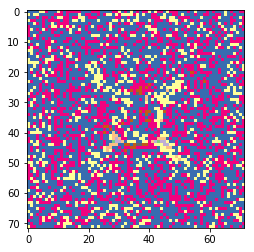

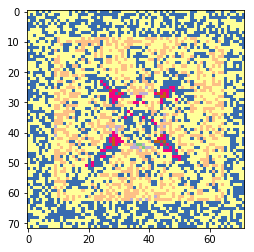

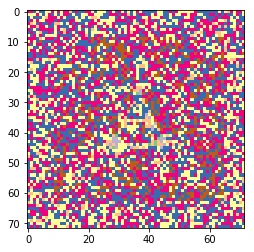

In [17]:
######################################## 4/ VISUALISATION OF THE SOLUTION #################################

def visualize_three_columns(model):
    c1 = model.get_weights()[0][:,0]
    plt.imshow(c1.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='Accent')
    plt.show()

    c2 = model.get_weights()[0][:,1]
    plt.imshow(c2.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='Accent')
    plt.show()

    c3 = model.get_weights()[0][:,2]
    plt.imshow(c3.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='Accent')
    plt.show()

visualize_three_columns(model)

### 5) A More Diffcult Classifcation Problem
__Train a convolutional (not-to-)deep network on a new dataset where the shapes are now allowed to move within the images and change dimensions.__

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Epoch 1/10
900/900 [==============================] - 0s 65us/step - loss: 2.9748 - get_categorical_accuracy_keras: 0.3622
Epoch 2/10
900/900 [==============================] - 0s 56us/step - loss: 2.1358 - get_categorical_accuracy_keras: 0.4133
Epoch 3/10
900/900 [==============================] - 0s 58us/step - loss: 1.4326 - get_categorical_accuracy_keras: 0.4867
Epoch 4/10
900/900 [==============================] - 0s 63us/step - loss: 1.2266 - get_categorical_accuracy_keras: 0.4889
Epoch 5/10
900/900 [

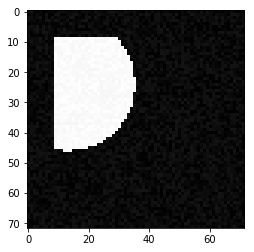

In [15]:
#################################### 5/ A MORE DIFFICULT CLASSIFICATION PROBLEM ###################################

[X_train_2, Y_train_2] = generate_dataset_classification(900, 20, True)
[X_test_2, Y_test_2] = generate_test_set_classification()

# Let's try to use our first simple model on this new dataset
model.fit(X_train_2, Y_train_2, epochs = 10, batch_size = 32)

plt.imshow(X_train_2[0].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap = cm.Greys)

print ("X_train_2 shape: " + str(X_train_2.shape))
print ("Y_train_2 shape: " + str(Y_train_2.shape))

# Check the Loss and Accuracy of our model 
scores = model.evaluate(X_test_2, Y_test_2, batch_size = 32)
print('Scores from model [Loss, Accuracy] => ', scores)

#### ==> Here, we see that our first simple model is not performing well on this new dataset : <br> 
__Scores from simple model =>  [Loss : 1.03, Accuracy: 0.47]__


In [16]:
# Create a new multi layer network to work on this new dataset
model_2 = Sequential()

model_2.add(Conv2D(16, (5,5), activation = 'relu', input_shape = (72, 72, 1)))
model_2.add(MaxPooling2D(pool_size = (2,2)))
model_2.add(Flatten())
model_2.add(Dropout(0.5))
model_2.add(Dense(3, activation='softmax'))

print(model_2.summary())
print(model_2.output_shape)

# Reshaping the data to use it in our new model: 
X_train_2 = X_train_2.reshape(X_train_2.shape[0], 72, 72, 1)
X_train_2 = X_train_2.astype('float32')
X_test_2 = X_test_2.reshape(X_test_2.shape[0], 72, 72, 1)
X_test_2 = X_test_2.astype('float32')


print ("X_train_2 shape: " + str(X_train_2.shape))
print ("Y_train_2 shape: " + str(Y_train_2.shape))
print ("X_test_2 shape: " + str(X_test_2.shape))
print ("Y_test_2 shape: " + str(Y_test_2.shape))


model_2.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=[get_categorical_accuracy_keras])

model_2.fit(X_train_2, Y_train_2, epochs = 30, batch_size = 32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 68, 68, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18496)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 55491     
Total params: 55,907
Trainable params: 55,907
Non-trainable params: 0
_________________________________________________________________
None
(None, 3)
X_train_2 shape: (900, 72, 72, 1)
Y_train_2 shape: (900, 3)
X_test_2 shape: (300, 72, 72, 1)
Y_test_2 shape: (300, 3)
Epoch

In [18]:
scores_2 = model_2.evaluate(X_test_2, Y_test_2, batch_size = 32)
print('Scores from model_2 [Loss, Accuracy] => ', scores_2)

300/300 [==============================] - 0s 922us/step
Scores from model_2 [Loss, Accuracy] =>  [0.40536225398381553, 0.8566666658719381]


#### ==> Here, we see that our new (not-too)deep network is performing much better on the more difficult dataset :
__Scores from model_2 on the test set =>  [Loss : 0.43, Accuracy : 0.88]__

### 6) A Regression Problem 
__The task now is to predict the image locations of the vertices of a triangle, given an image of this
triangle.__ <br>
__1/ With our previous model__

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890


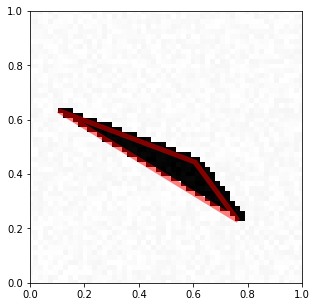

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
X_train_3 shape: (900, 72, 72, 1)
Y_train_3 shape: (900, 6)
X_test_3 shape: (300, 72, 72, 1)
Y_test_3 shape: (300, 6)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 68, 68, 64)        1664      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 34, 34, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 32)        51232     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 16)        4624      
________________________________

In [19]:
###################################### 6/ A REGRESSION PROBLEM #######################################

[X_train_3, Y_train_3] = generate_dataset_regression(900, 10)

visualize_prediction(X_train_3[1], Y_train_3[1])

[X_test_3, Y_test_3] = generate_test_set_regression()

# Reshaping the data 
X_train_3 = X_train_3.reshape(X_train_3.shape[0], 72, 72, 1)
X_train_3 = X_train_3.astype('float32')
X_test_3 = X_test_3.reshape(X_test_3.shape[0], 72, 72, 1)
X_test_3 = X_test_3.astype('float32')

# Taking a look at the shape of our inputs
print ("X_train_3 shape: " + str(X_train_3.shape))
print ("Y_train_3 shape: " + str(Y_train_3.shape))
print ("X_test_3 shape: " + str(X_test_3.shape))
print ("Y_test_3 shape: " + str(Y_test_3.shape))

# Creating our third model for regression
model_3 = Sequential()

# The layers
model_3.add(Conv2D(64, (5,5), activation = 'relu', input_shape = (72, 72, 1)))
model_3.add(MaxPooling2D(pool_size = (2,2)))
model_3.add(Conv2D(32, (5,5), activation = 'relu'))
model_3.add(MaxPooling2D(pool_size = (2,2)))
model_3.add(Conv2D(16, (3,3), activation='relu'))
model_3.add(MaxPooling2D(pool_size = (2,2)))
model_3.add(Flatten())
model_3.add(Dropout(0.25))
model_3.add(Dense(6, activation = 'linear'))

model_3.summary()



In [20]:
# Compiling the model with a Mean Squared Error loss function and Mean absolute error metrics 
model_3.compile(loss='mean_squared_error', optimizer = 'rmsprop', metrics=[get_categorical_accuracy_keras])

# Fitting the model on our training data
model_3.fit(X_train_3, Y_train_3, epochs=20, batch_size=32)

# Testing the model on our test data
scores_3 = model_3.evaluate(X_test_3, Y_test_3, batch_size = 32)
print('Scores from model_3 [Loss, Accuracy] => ', scores_3)

Epoch 1/20
900/900 [==============================] - 11s 12ms/step - loss: 0.1335 - get_categorical_accuracy_keras: 0.1756
Epoch 2/20
900/900 [==============================] - 11s 12ms/step - loss: 0.0903 - get_categorical_accuracy_keras: 0.2178
Epoch 3/20
900/900 [==============================] - 13s 14ms/step - loss: 0.0794 - get_categorical_accuracy_keras: 0.2333
Epoch 4/20
900/900 [==============================] - 12s 13ms/step - loss: 0.0779 - get_categorical_accuracy_keras: 0.2333
Epoch 5/20
900/900 [==============================] - 11s 12ms/step - loss: 0.0727 - get_categorical_accuracy_keras: 0.2378
Epoch 6/20
900/900 [==============================] - 11s 12ms/step - loss: 0.0699 - get_categorical_accuracy_keras: 0.2900
Epoch 7/20
900/900 [==============================] - 11s 12ms/step - loss: 0.0667 - get_categorical_accuracy_keras: 0.2811
Epoch 8/20
900/900 [==============================] - 12s 13ms/step - loss: 0.0645 - get_categorical_accuracy_keras: 0.2978
Epoch 9/

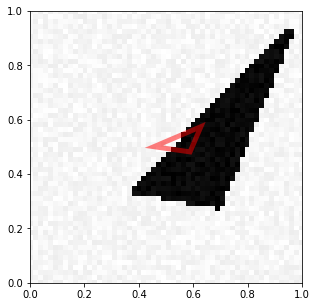

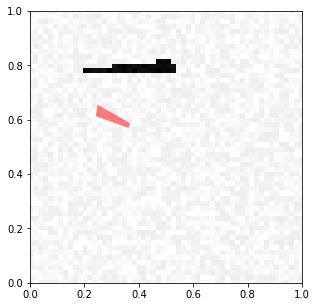

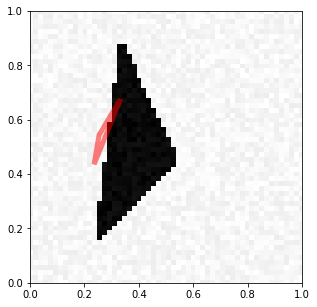

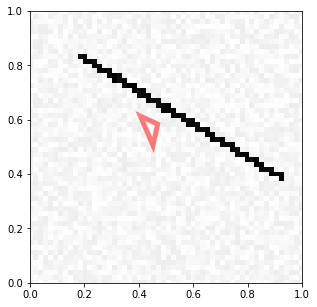

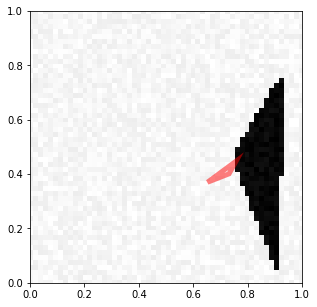

In [21]:
# Visualizing our predictions
for i in range(0, 5):
    visualize_prediction(X_test_3[i], model_3.predict(X_test_3[i].reshape(1, 72, 72, 1)))

#### ==> Here, we see that our deep network doesn't seem to work very well on this problem, even with more layers.

#### 2/ We will try using a nnormalization / sorting method :
The idea is to sort in the first place the 'Y_train' before we train the model. The sorting is done as follow:



In [22]:
# Here is our sort function 
def sort_y(Y):
    #print('Y = ', Y)
    y_reshaped = list(map(lambda i: np.array(sorted(Y[i].reshape(3,2), key= lambda x:x[0])).reshape(6), range(len(Y))))
    return np.array(y_reshaped)

In [23]:
# Sorting Y_train and Y_test
Y_train_sorted = sort_y(Y_train_3)
Y_test_sorted = sort_y(Y_test_3)

# Have a look at the shape of our data 
print ("Y_train_sorted shape: " + str(Y_train_sorted.shape))
print ("Y_test_sorted shape: " + str(Y_test_sorted.shape))


Y_train_sorted shape: (900, 6)
Y_test_sorted shape: (300, 6)


In [24]:
# Define a new model, equivalent to the one we used before
model_4 = Sequential()
model_4.add(Conv2D(16, kernel_size=(5,5), activation='relu', input_shape=(72,72,1)))
model_4.add(MaxPooling2D(pool_size=(2,2), padding="same"))
model_4.add(Flatten())
model_4.add(Dense(128, activation='relu'))
model_4.add(Dense(6,activation='linear'))

# Have a look at our model 

# Compiling and fitting our model
model_4.compile(optimizer='adam', loss='mean_squared_error' , metrics=[get_categorical_accuracy_keras] )
model_4.fit(X_train_3, Y_train_sorted, batch_size= 16 , epochs=30)

Epoch 1/30
900/900 [==============================] - 4s 4ms/step - loss: 0.1758 - get_categorical_accuracy_keras: 0.4678
Epoch 2/30
900/900 [==============================] - 3s 3ms/step - loss: 0.0289 - get_categorical_accuracy_keras: 0.5967
Epoch 3/30
900/900 [==============================] - 3s 3ms/step - loss: 0.0190 - get_categorical_accuracy_keras: 0.6833
Epoch 4/30
900/900 [==============================] - 3s 3ms/step - loss: 0.0146 - get_categorical_accuracy_keras: 0.7022
Epoch 5/30
900/900 [==============================] - 3s 3ms/step - loss: 0.0126 - get_categorical_accuracy_keras: 0.7556
Epoch 6/30
900/900 [==============================] - 3s 4ms/step - loss: 0.0090 - get_categorical_accuracy_keras: 0.7844
Epoch 7/30
900/900 [==============================] - 3s 4ms/step - loss: 0.0074 - get_categorical_accuracy_keras: 0.7933
Epoch 8/30
900/900 [==============================] - 3s 3ms/step - loss: 0.0060 - get_categorical_accuracy_keras: 0.8067
Epoch 9/30
900/900 [====

In [25]:
# Evaluating our model on test data
model_4.evaluate(X_test_3, Y_test_sorted)

300/300 [==============================] - 0s 1ms/step


[0.02592439646522204, 0.68]

#### ==> We see that our results are much higher than without the sorting, reaching more than 65% on our test set

- Let's take a better look at our predicted values

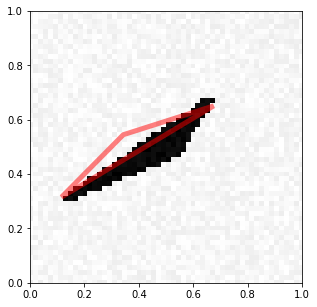

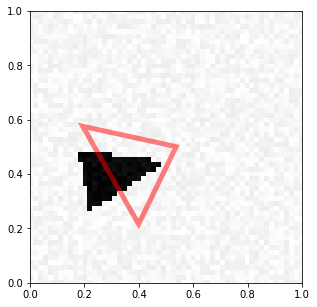

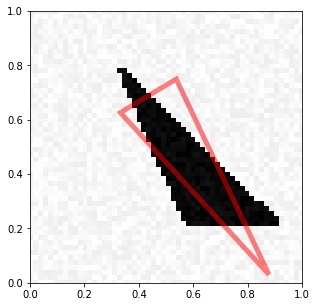

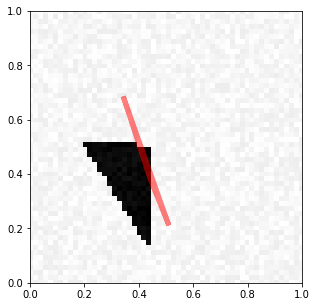

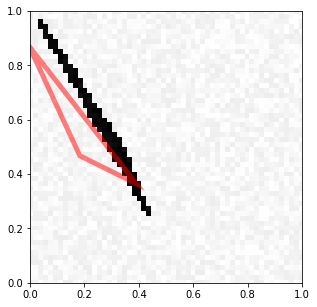

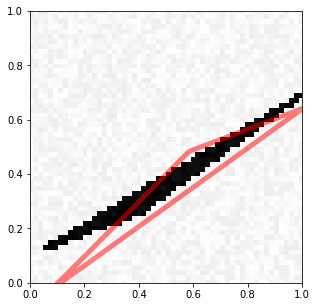

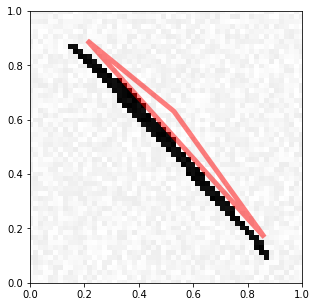

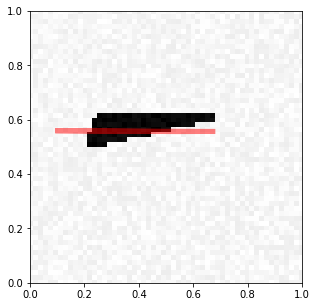

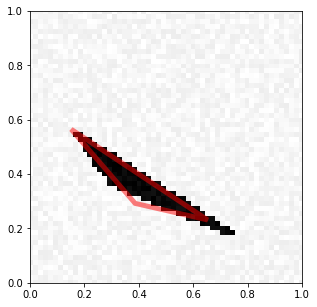

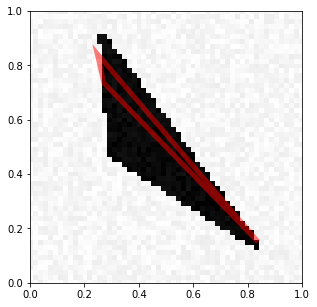

In [26]:
import random as rd

# Testing our prediction and visualizing it
preds_reg_sorted= model_4.predict(X_test_3)

range_test = list(range(299))

idx_img = rd.sample(range_test, 10)
for i in idx_img :
    visualize_prediction(X_test_3[i], preds_reg_sorted[i])

## We see that the results obtained are not perfect, but they fit pretty well the general shape of our triangles and can capture their location on the image

### 7) Image Denoising
__Train your network to predict a noise-free image given a noisy
image as input.__

In [27]:
# Modifying our generates function to get two images as output

def generate_a_rectangle_2(noise, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0)

def generate_a_disk_2(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise) , generate_a_drawing(figsize, U, V, 0)

def generate_a_triangle_2(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    
    imdata = generate_a_drawing(figsize, U, V, 0)
    imdata_noise = generate_a_drawing(figsize, U, V, noise)
    return [imdata_noise,imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

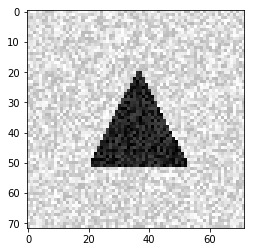

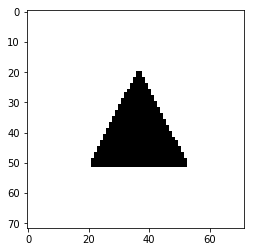

In [28]:
# Plotting our two images 
[im, im_noise, v] = generate_a_triangle_2(100, False)
plt.imshow(im.reshape(72,72), cmap='gray')
plt.show()
plt.imshow(im_noise.reshape(72,72), cmap='gray')
plt.show()

In [29]:
# Here is our new dataset generations using our new generates function

def generate_a_dataset(nb_samples, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle_2(0)[0].shape[0]
    X = np.zeros([nb_samples,im_size])   #Images with noise
    Y = np.zeros([nb_samples,im_size])   #Images without noise
    for i in range(nb_samples):
        category = np.random.randint(3)
        #Each image is generated with a different random level of noise
        noise =rd.randint(20,150)
        if category == 0:
            X[i] , Y[i]= generate_a_rectangle_2(noise, free_location)
        elif category == 1: 
            X[i] , Y[i]= generate_a_disk_2(noise, free_location)
        else:
            [X[i], Y[i], V] = generate_a_triangle_2(noise, free_location)
    X = (X + 0) / (255 + 2 * 0)
    Y = (Y + noise) / (255 + 2 * noise)
    return [X, Y]

In [30]:
# Generating the noisy training and test set
[X_train_noise, Y_train_noise] = generate_a_dataset(300)
[X_test_noise, Y_test_noise] = generate_a_dataset(300)

In [31]:
# Formatting the input for the training
X_train_noise = X_train_noise.reshape(X_train_noise.shape[0], 72, 72, 1)
X_train_noise = X_train_noise.astype('float32')
print(X_train_noise.shape)

# Formatting the output for the training
Y_train_noise = Y_train_noise.reshape(Y_train_noise.shape[0], 72, 72, 1)
Y_train_noise = Y_train_noise.astype('float32')
print(Y_train_noise.shape)


# Formatting the input
Y_test_noise = Y_test_noise.reshape(Y_test_noise.shape[0], 72, 72, 1)
Y_test_noise = Y_test_noise.astype('float32')
print(Y_test_noise.shape)

(300, 72, 72, 1)
(300, 72, 72, 1)
(300, 72, 72, 1)


In [32]:
from keras.layers import Input
input_img = Input(shape=(72,72,1))

__The hourglass network architecture should contain two parts :__

A/ Encoded part: convolutional + a pool layers <br>
B/ Decoder part: unsampling + convolutional layers <br>
These two parts are symetric

In [33]:
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
autoencoder.summary()

autoencoder.fit(X_train_noise, Y_train_noise, epochs=50, batch_size=128, shuffle=True, validation_split=0.3)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 72, 72, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 36, 36, 32)        9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 1)         289       
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Train on

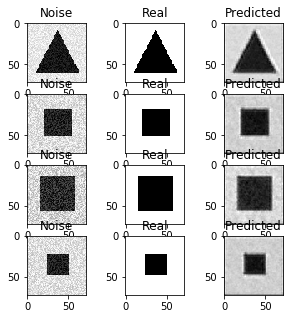

In [34]:
# Here we will do our prediction
pred_noise = autoencoder.predict(X_train_noise)

# And observe the predictions from our model by plotting the Noisy, Real and Predicted figures
nb_img_test = 4
pos =1

fig, axes = plt.subplots(4, 3,figsize=(5,5))

for j in range(nb_img_test):
    
    i=rd.randint(0,299)   
    
    axes[j, 0].imshow(X_train_noise[i].reshape(72,72), cmap='gray')
    axes[j, 0].set_title('Noise')

    axes[j, 1].imshow(Y_train_noise[i].reshape(72,72), cmap='gray')
    axes[j, 1].set_title('Real')
    
    axes[j, 2].imshow(pred_noise[i].reshape(72,72), cmap='gray')
    axes[j, 2].set_title('Predicted')

We see that the model is capable of capturing the figure and reducing the noise around it 